In [5]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun

In [6]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)

full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')

In [7]:
start = 900000
end = start + 2000
data = full_data[start:end]
data.reset_index(drop=True, inplace=True)

all_events = PointProcessTrain(data, xgridsize = 50, ygridsize = 50, w = [.1, .01,.0001], time_scale_label = '15minutes')

data.head()


,CALL_TYPE_FINAL,CALL_TYPE_FINAL_D,YCOORD,XCOORD,DATE_TIME
0,775A,DIABETIC,39.744822,-86.133730,2016-08-21 05:15:47
1,770B,ABDOMIN/BACK PN,39.883948,-86.177633,2016-08-21 05:19:49
2,770B,ABDOMIN/BACK PN,39.795276,-86.163197,2016-08-21 05:20:41
3,770A,ABDOMIN/BACK PN,39.646971,-86.119972,2016-08-21 05:28:21
4,764B,NEURO/HEAD INJ,39.811284,-86.071995,2016-08-21 05:29:41


In [8]:
all_events.train()

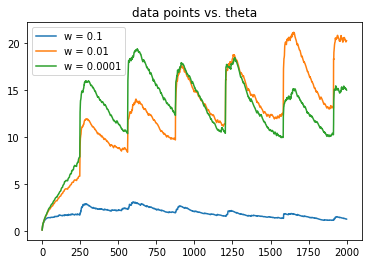


Hour vector: 
[0.04352405 0.05271239 0.0738802  0.03580442 0.01802073 0.06337293
 0.02370859 0.0555141  0.05078807 0.03697089 0.02179373 0.02343741
 0.03269422 0.02983343 0.02473784 0.04027098 0.0304893  0.05707928
 0.0617833  0.06047177 0.04672737 0.02973016 0.03944448 0.04721036]
Day vector: 
[9.25857953e-33 9.14812943e-26 1.85348804e-18 5.40778975e-10
 1.21403172e-02 9.87859682e-01 9.37033883e-40]


In [9]:
all_events.param_examine()

In [10]:
all_events.model_hotspot_examine(1000)

Location and value of largest and smallest sum(Lambda): 
102.10977065580549 (17, 20) 5.6723811796088786 (0, 0)

Location of grid with most events:
31.0 (17, 21)

Historical time period is 277.01219452099997 15minutes

Trained hotspots in real top 10
Grid: (17, 20), Model: 28.285651651400688, Real: 30
Grid: (17, 21), Model: 24.589449706336406, Real: 31
Grid: (17, 27), Model: 16.358373243837804, Real: 13
Grid: (17, 22), Model: 15.983553085490176, Real: 13
Grid: (20, 21), Model: 13.99518214483804, Real: 12
Grid: (19, 22), Model: 13.459817067285943, Real: 14
Grid: (16, 25), Model: 11.94161839984701, Real: 14
Grid: (26, 28), Model: 11.898369489654383, Real: 12

Trained hotstpots not in real top 10
Grid: (22, 23), Model: 11.368389200771533, Real: 11
Grid: (19, 19), Model: 11.252763299941309, Real: 4

Real top 10 hotspots not in trained model
Grid: (16, 21), Model: 10.997776020080698, Real: 12
Grid: (17, 25), Model: 10.578997351407885, Real: 11


In [13]:
test_points = full_data[end:end+1000]
test_points.reset_index(drop=True, inplace=True)
all_events_simulate = PointProcessRun()
intensities1, pred1 = all_events_simulate.test_projection(test_points)

Intensities are in units of #/15minutes

Predicting over time of 302.794414165 15minutes. Generating 303 intensity prediction(s)

Predicted hotspots in real top 10
Grid: (17, 21), Model: 1133.1037984238046, Real: 28.0
Grid: (17, 20), Model: 832.461710423476, Real: 41.0
Grid: (17, 27), Model: 507.11388239599927, Real: 19.0
Grid: (20, 21), Model: 455.9529450097987, Real: 12.0
Grid: (17, 22), Model: 405.74799196247324, Real: 12.0
Grid: (21, 21), Model: 398.44156392136097, Real: 17.0

Predicted hotstpots not in real top 10
Grid: (20, 22), Model: 539.018428981373, Real: 4.0
Grid: (19, 22), Model: 477.37486628548186, Real: 8.0
Grid: (18, 25), Model: 421.37526031876826, Real: 9.0
Grid: (16, 25), Model: 394.9324113817205, Real: 10.0

Real top 10  hotspots not predicted
Grid: (14, 23), Model: 110.00120452947513, Real: 13.0
Grid: (19, 6), Model: 116.101350084645, Real: 13.0
Grid: (19, 23), Model: 202.67606298134365, Real: 12.0
Grid: (19, 21), Model: 152.0089779494114, Real: 11.0
